# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [46]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
# !pip install smdebug
!pip install sns

  Preparing metadata (setup.py) ... done
  Created wheel for sns: filename=sns-0.1-py3-none-any.whl size=2638 sha256=78e032654aabf98808b0217dd79a9e1321265a9362aca4c44b40fe7f2eb8b03b
  Stored in directory: /root/.cache/pip/wheels/cc/26/02/785cf1aeaa8d9e565796a1b962467bcdf62172c8fe12096ffb
Successfully built sns
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [64]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
from sagemaker import get_execution_role

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [155]:
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner, IntegerParameter
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import Predictor as sagemaker_predictor

In [82]:
from sagemaker.debugger import Rule, rule_configs, ProfilerRule, DebuggerHookConfig, CollectionConfig, ProfilerConfig, FrameworkProfile

In [138]:
import json
import os
import IPython
import numpy as np
from PIL import Image
import io
import random

### References

* https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#deploy-endpoints-from-model-data

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
# !unzip dogImages.zip

In [ ]:
# !unzip dogImages.zip

In [65]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = get_execution_role() 
print(bucket)
print(role)

sagemaker-us-east-1-204883889828
arn:aws:iam::204883889828:role/service-role/AmazonSageMaker-ExecutionRole-20230830T103496


In [11]:
upload_data = False

if upload_data:
    s3_path_to_data = sagemaker.Session().upload_data(
        bucket=bucket, 
        path='dogImages', 
        key_prefix='dogImages'
    )

In [69]:
print(s3_path_to_data)

s3://sagemaker-us-east-1-204883889828/dogImages


#### EDA

some figures about the dog data

In [36]:
## saving file names in a dataframe
mani_data = {
    'data_split':list(),
    'dog_breed':list(),
    'filename':list()
}

s3 = boto3.resource('s3', region_name='us-east-1') 
s3_bucket = s3.Bucket(bucket) 
for my_bucket_object in s3_bucket.objects.filter(Prefix='dogImages/'):
    key = my_bucket_object.key 
    tockens = key.split('/')
    if len(tockens) == 4:
        mani_data['data_split'].append(tockens[1])
        mani_data['dog_breed'].append(tockens[2])
        mani_data['filename'].append(tockens[3])
        
df_data = pd.DataFrame(mani_data)

/opt/conda/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [38]:
df_data.head()

data_split          dog_breed                 filename
0       test  001.Affenpinscher  Affenpinscher_00003.jpg
1       test  001.Affenpinscher  Affenpinscher_00023.jpg
2       test  001.Affenpinscher  Affenpinscher_00036.jpg
3       test  001.Affenpinscher  Affenpinscher_00047.jpg
4       test  001.Affenpinscher  Affenpinscher_00048.jpg

number of images by data split

In [40]:
df_data.groupby('data_split').agg(count = ('filename','count'))

count
data_split       
test          836
train        6680
valid         835

number of images by breed

In [43]:
summary = df_data.groupby(['data_split','dog_breed'],as_index = False).agg(count = ('filename','count'))

In [59]:
summary.head(5)

data_split             dog_breed  count
0       test     001.Affenpinscher      8
1       test      002.Afghan_hound      8
2       test  003.Airedale_terrier      6
3       test             004.Akita      8
4       test  005.Alaskan_malamute     10

In [71]:
print('number of classes: ', len(summary[summary.data_split == 'train'].dog_breed.unique()))

number of classes:  133


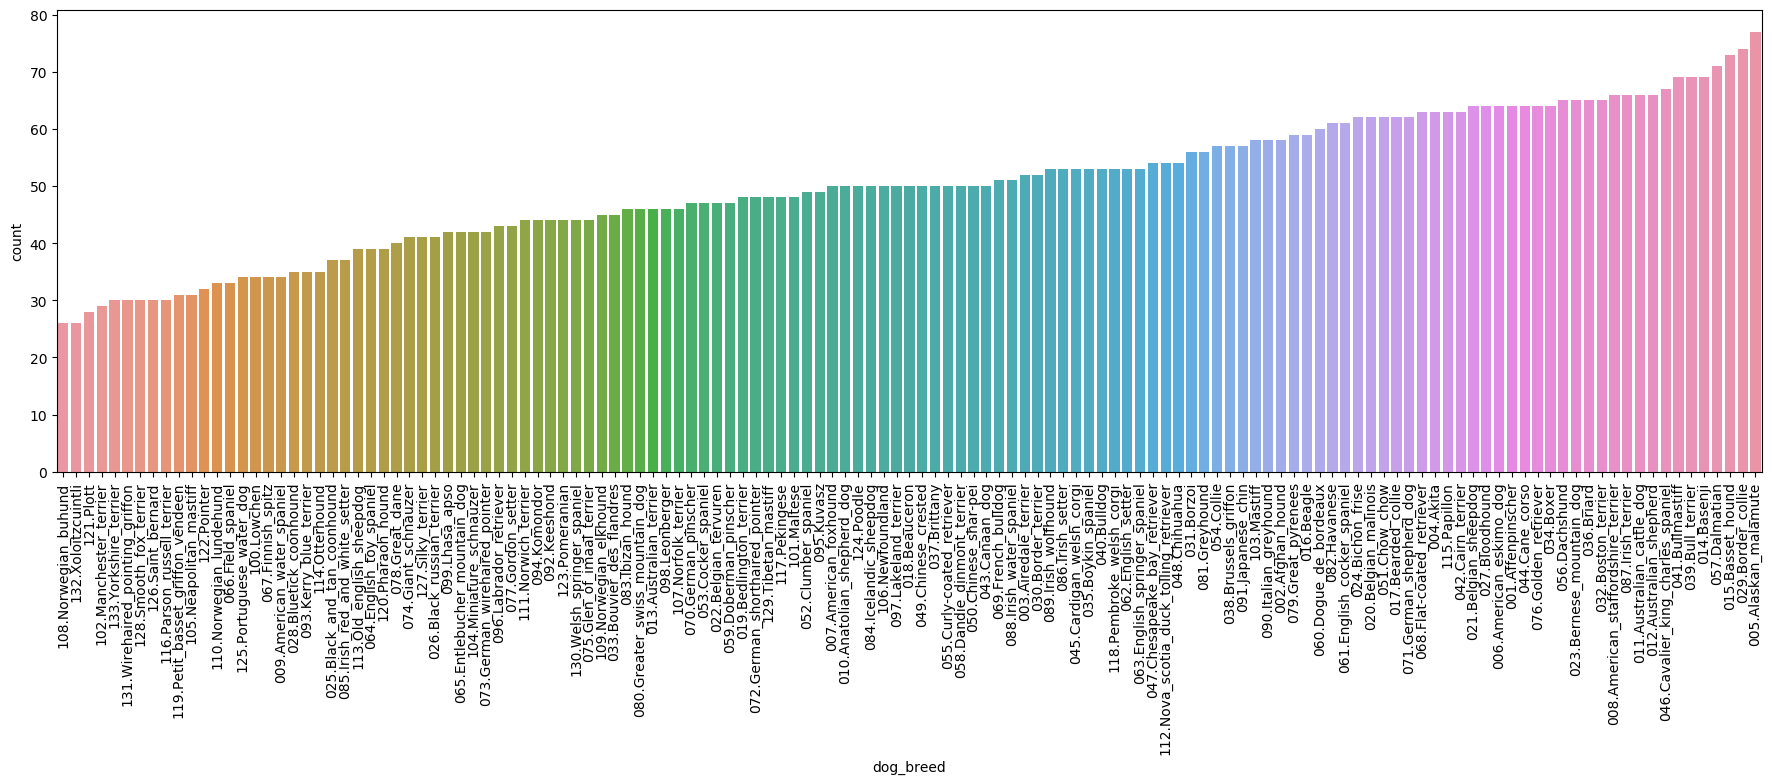

In [56]:
f, ax = plt.subplots(figsize = (22,6))
sns.barplot(data=summary[summary.data_split == 'train'].sort_values('count'), x="dog_breed", y="count")
plt.xticks(rotation=90)
plt.show()

In [57]:
f, ax = plt.subplots(figsize = (22,6))
sns.barplot(data=summary[summary.data_split == 'valid'].sort_values('count'), x="dog_breed", y="count")
plt.xticks(rotation=90)
plt.show()

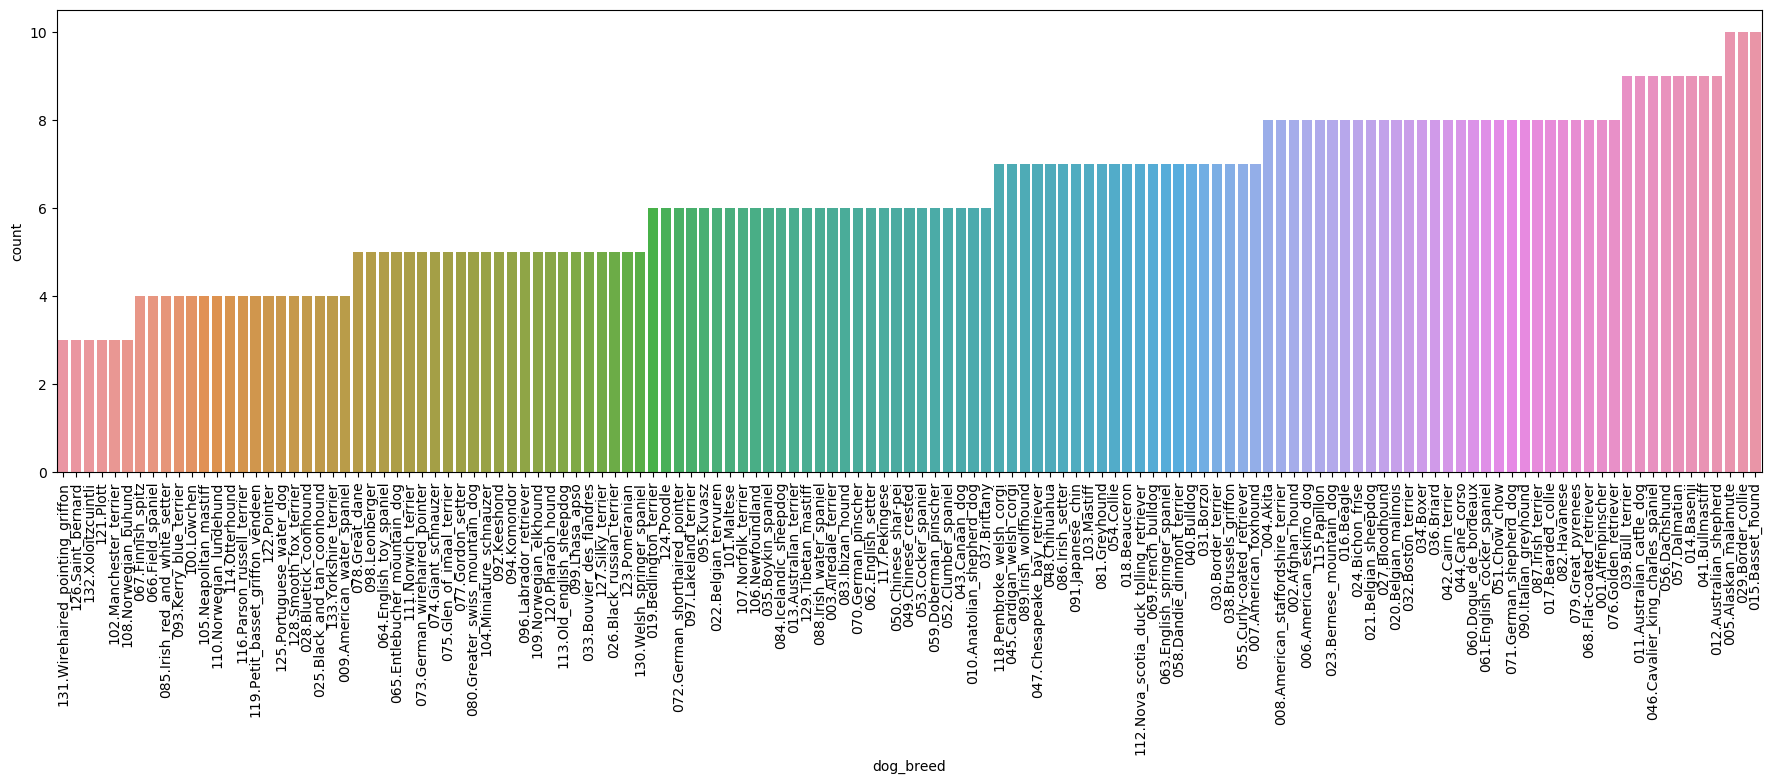

In [58]:
f, ax = plt.subplots(figsize = (22,6))
sns.barplot(data=summary[summary.data_split == 'test'].sort_values('count'), x="dog_breed", y="count")
plt.xticks(rotation=90)
plt.show()

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [66]:
#TODO: Declare your HP ranges, metrics etc.

hyperparameter_ranges = {
    'lr': ContinuousParameter(0.001, 0.1),
    'batch_size': CategoricalParameter([16 ,32, 64]),
    'epochs': IntegerParameter(2, 6)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [75]:
estimator = PyTorch(
    entry_point = 'hpo.py',
    base_job_name = 'dogbreed-classification-hpo',
    role = role,
    instance_count = 1,
    instance_type = 'ml.m5.2xlarge', 
    py_version = 'py36',
    framework_version = '1.8'
)

tuner = HyperparameterTuner(
    estimator = estimator,
    objective_metric_name = objective_metric_name,
    hyperparameter_ranges = hyperparameter_ranges,
    metric_definitions = metric_definitions,
    max_jobs = 4,
    max_parallel_jobs = 1,
    objective_type = objective_type
)

In [78]:
tuner.fit({'train': s3_path_to_data}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................................................................................................................................................!


In [79]:
best_estimator = tuner.best_estimator()

best_estimator.hyperparameters()


2023-08-31 10:01:36 Starting - Found matching resource for reuse
2023-08-31 10:01:36 Downloading - Downloading input data
2023-08-31 10:01:36 Training - Training image download completed. Training in progress.
2023-08-31 10:01:36 Uploading - Uploading generated training model
2023-08-31 10:01:36 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'epochs': '3',
 'lr': '0.014088958140267716',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dogbreed-classification-hpo-2023-08-31-09-45-07-168"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-204883889828/dogbreed-classification-hpo-2023-08-31-09-45-07-168/source/sourcedir.tar.gz"'}

In [84]:
best_hyperparameters = {
    'batch_size': 64,
    'epochs': 3,
    'lr': 0.014088958140267716
}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [83]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, 
    framework_profile_params = FrameworkProfile(num_steps=10)
)

collection_config = [
    CollectionConfig(
        name="CrossEntropyLoss_output_0", 
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "10",
            "eval.save_interval": "1"
            }
        )
]

debugger_config = DebuggerHookConfig(collection_configs = collection_config)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [85]:
estimator = PyTorch(
    entry_point = 'train_model.py',
    role = role,
    instance_count=1,
    instance_type = 'ml.m5.2xlarge',
    py_version = 'py36',
    framework_version = '1.6',
    hyperparameters = best_hyperparameters,
    profiler_config = profiler_config, 
    debugger_hook_config = debugger_config, 
    rules = rules 
) 

In [89]:
estimator.fit({'train':s3_path_to_data}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-08-31-12-37-16-995


Using provided s3_resource
2023-08-31 12:37:17 Starting - Starting the training job...
2023-08-31 12:37:40 Starting - Preparing the instances for trainingVanishingGradient: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-08-31 12:38:47 Downloading - Downloading input data......
2023-08-31 12:39:47 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-08-31 12:39:52,390 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-08-31 12:39:52,393 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-08-31 12:39:52,403 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-08-31 12:39:52,406 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-08-31 12:39:52,659 sagemaker-training-to

In [101]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
# description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
rule_logs = estimator.latest_training_job.job_name + "/rule-output"
rule_output_path = estimator.output_path + rule_logs

print(f"Jobname is: {job_name}")
print(f"Client is: {client}")
# print(f"Description: {description}")
print(f'rule output location: {rule_output_path}')

Jobname is: pytorch-training-2023-08-31-12-37-16-995
Client is: <botocore.client.SageMaker object at 0x7f531d5469d0>
rule output location: s3://sagemaker-us-east-1-204883889828/pytorch-training-2023-08-31-12-37-16-995/rule-output


In [103]:
debug_logs = estimator.latest_training_job.job_name + "/debug-output"
debug_output_path = estimator.output_path + debug_logs

print(f'Profiler location: {debug_output_path}')

Profiler location: s3://sagemaker-us-east-1-204883889828/pytorch-training-2023-08-31-12-37-16-995/debug-output


In [105]:
profiler_logs = estimator.latest_training_job.job_name + "/profiler-output"
profiler_output_path = estimator.output_path + debug_logs

print(f'Profiler location: {profiler_output_path}')

Profiler location: s3://sagemaker-us-east-1-204883889828/pytorch-training-2023-08-31-12-37-16-995/profiler-output


In [123]:
s3 = boto3.resource('s3', region_name='us-east-1') 
s3_bucket = s3.Bucket(bucket) 
for my_bucket_object in s3_bucket.objects.filter(Prefix=f'{debug_output_path}/'):
    key = my_bucket_object.key 
    print(key)

importing the rule outputs

In [100]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-204883889828/pytorch-training-2023-08-31-12-37-16-995/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-204883889828/pytorch-training-2023-08-31-12-37-16-995/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-204883889828/pytorch-training-2023-08-31-12-37-16-995/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-204883889828/pytorch-training-2023-08-31-12-37-16-995/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-204883889828/pytorch-training-2023-08-31-12-37-

In [120]:
profiler_output_path

's3://sagemaker-us-east-1-204883889828/pytorch-training-2023-08-31-12-37-16-995/profiler-output'

In [ ]:
# ! aws s3 cp {profiler_output_path} ./ --recursive

In [117]:
import json

f = open('../project_3/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json')
data = json.load(f)

In [118]:
data

{'RuleTriggered': 0,
 'Violations': 0,
 'Details': {},
 'Datapoints': 0,
 'RuleParameters': 'threshold:0.2\npatience:1000'}

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

yes, but in this last training job there is not issues. In a previous training job I got an issue with poor initial weights to start the training job

In [128]:
profiler_report_name = 'ProfilerReport'

In [180]:
IPython.display.HTML(filename= profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [131]:
model_location = estimator.model_data
print(f'model location: {model_location}')

model location: s3://sagemaker-us-east-1-204883889828/pytorch-training-2023-08-31-12-37-16-995/output/model.tar.gz


In [158]:
## this helper configurations help to deploy the model in a more friendly manner (at least to read other jpg files)
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImgPredictor(sagemaker_predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super(ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel(model_data = model_location,
                             role = role,
                             entry_point= "inference.py",
                             py_version = "py36",
                             framework_version = "1.6",
                             predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy(initial_instance_count = 1, instance_type = "ml.m5.2xlarge")

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-204883889828/pytorch-training-2023-08-31-12-37-16-995/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-204883889828/pytorch-inference-2023-08-31-15-18-12-080/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-08-31-15-18-20-858
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-08-31-15-18-21-677
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-08-31-15-18-21-677


----!

In [159]:
test_images_jpgs = list()
s3 = boto3.resource('s3', region_name='us-east-1') 
s3_bucket = s3.Bucket(bucket) 
for my_bucket_object in s3_bucket.objects.filter(Prefix='dogImages/test'):
    key = my_bucket_object.key
    test_images_jpgs.append(key)

In [177]:
random.shuffle(test_images_jpgs)
n_sample = 10
sample_images = test_images_jpgs[0:n_sample]

In [178]:
print('sample images to test: ',sample_images)

sample images to test:  ['dogImages/test/129.Tibetan_mastiff/Tibetan_mastiff_08158.jpg', 'dogImages/test/127.Silky_terrier/Silky_terrier_08040.jpg', 'dogImages/test/087.Irish_terrier/Irish_terrier_05903.jpg', 'dogImages/test/023.Bernese_mountain_dog/Bernese_mountain_dog_01646.jpg', 'dogImages/test/057.Dalmatian/Dalmatian_04006.jpg', 'dogImages/test/019.Bedlington_terrier/Bedlington_terrier_01340.jpg', 'dogImages/test/017.Bearded_collie/Bearded_collie_01215.jpg', 'dogImages/test/097.Lakeland_terrier/Lakeland_terrier_06550.jpg', 'dogImages/test/023.Bernese_mountain_dog/Bernese_mountain_dog_01638.jpg', 'dogImages/test/002.Afghan_hound/Afghan_hound_00149.jpg']


--------------------------------------------------------
the test image is:


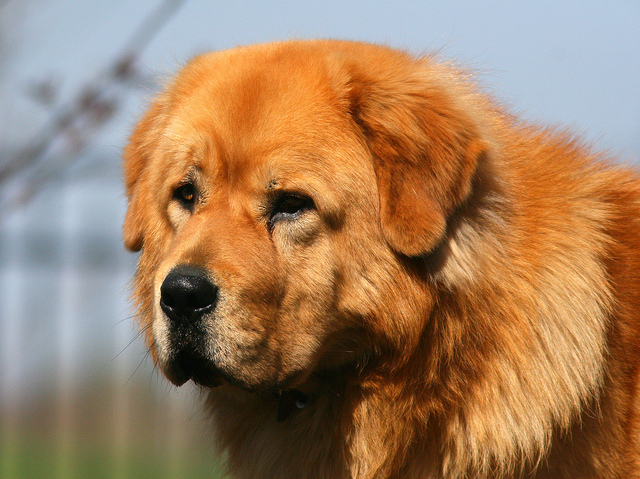

results are:
prediceted class: 51
true label is: 129
prediction was correct?? False
--------------------------------------------------------
the test image is:


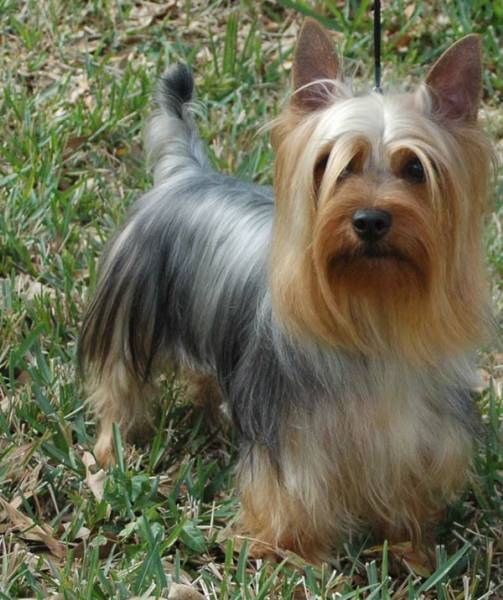

results are:
prediceted class: 133
true label is: 127
prediction was correct?? False
--------------------------------------------------------
the test image is:


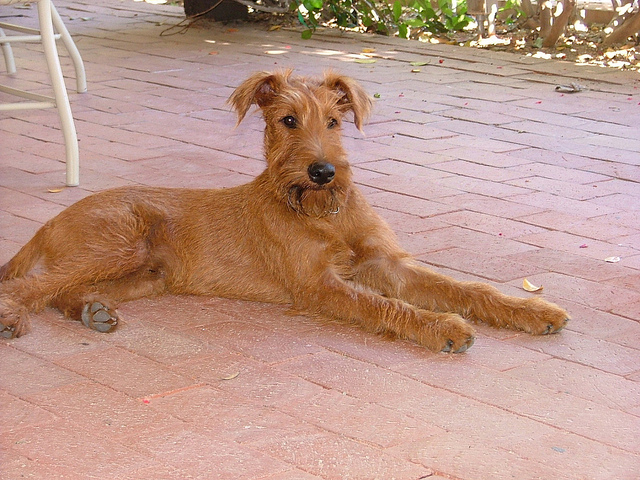

results are:
prediceted class: 87
true label is: 87
prediction was correct?? True
--------------------------------------------------------
the test image is:


results are:
prediceted class: 23
true label is: 23
prediction was correct?? True
--------------------------------------------------------
the test image is:


results are:
prediceted class: 57
true label is: 57
prediction was correct?? True
--------------------------------------------------------
the test image is:


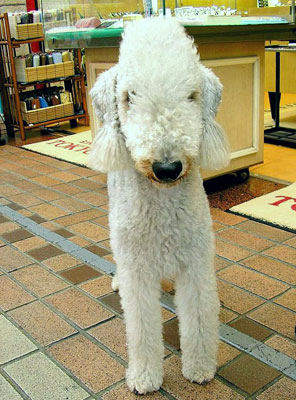

results are:
prediceted class: 19
true label is: 19
prediction was correct?? True
--------------------------------------------------------
the test image is:


results are:
prediceted class: 17
true label is: 17
prediction was correct?? True
--------------------------------------------------------
the test image is:


results are:
prediceted class: 73
true label is: 97
prediction was correct?? False
--------------------------------------------------------
the test image is:


results are:
prediceted class: 64
true label is: 23
prediction was correct?? False
--------------------------------------------------------
the test image is:


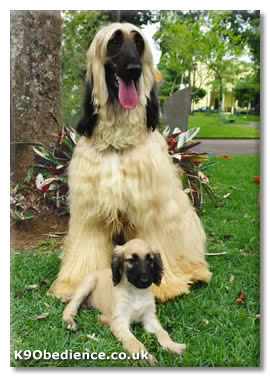

results are:
prediceted class: 98
true label is: 2
prediction was correct?? False


In [179]:
for i,sample_jpg in enumerate(sample_images):
    breed = sample_jpg.split('/')[2]
    label = int(breed.split('.')[0])
    data_location = 's3://{}/{}'.format(bucket, sample_jpg) 
    s3.Bucket(bucket).download_file(sample_jpg, 'tmp_image.jpg')
    with open('tmp_image.jpg' , "rb") as f:
        print('--------------------------------------------------------')
        print('the test image is:')
        payload = f.read()
        display(Image.open(io.BytesIO(payload)))
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"}) 
        predicted_dog_breed = np.argmax(response, 1) + 1
        predicted_dog_breed = predicted_dog_breed[0]
        print('results are:')
        print(f"prediceted class: {predicted_dog_breed}")
        print(f"true label is: {label}")
        print('prediction was correct??', label == predicted_dog_breed)
        

In [181]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-08-31-15-18-21-677
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-08-31-15-18-21-677
